### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 3 мая 2021, 08:30  
**Штраф за опоздание:** -2 балла после 08:30 03 мая, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import validation_curve
from scipy.stats import randint as randint
from sklearn.model_selection import StratifiedKFold

In [3]:
from sklearn.base import BaseEstimator

class MyDecisionTreeClassifier(BaseEstimator):
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini', \
                 min_IG=0.1, unique_features=True, data_percentage=0.05):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        self.feature_importances_ = dict()
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.min_IG = min_IG
        self.data_percentage = data_percentage
        self.unique_features = unique_features
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, int(feature_id)] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y, feature_set):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """        
        def criterion_(criterion, y, y_left, y_right):
            pl = np.bincount(y_left)
            pr = np.bincount(y_right)
            p0 = np.bincount(y)
            if criterion == 'gini':
                F0 = 1 - np.dot(p0, p0) / y.size**2
                Fleft = 1 - np.dot(pl, pl) / y_left.size**2
                Fright = 1 - np.dot(pr, pr) / y_right.size**2                 
            if criterion == 'entropy':
                log0 = np.log2(np.where(p_0==0, 1, p0)) - np.log2(y.size)
                logl = np.log2(np.where(p_l==0, 1, pl)) - np.log2(y_left.size)
                logr = np.log2(np.where(p_r==0, 1, pr)) - np.log2(y_right.size)
                F0 = - np.dot(p0, log0) / y.size 
                Fleft = - np.dot(pl, logl) / y_left.size                     
                Fright = - np.dot(pr, logr) / y_right.size
            if criterion == 'misclass':
                F0 = 1 - np.max(p0) / y.size                      
                Fleft = 1 - np.max(pl) / y_left.size                      
                Fright = 1 - np.max(pr) / y_right.size          
            IG = F0 - (y_left.size * Fleft + y_right.size * Fright) / y.size
            return IG
        
        def prepare_criteria_matrix(x, feature_mask):
            s_matr = np.sort(x[:, feature_mask], axis=0)
            datasize = x.shape[0]
            size = int(round(self.data_percentage * datasize))
            if size <= 1:
                sm_matr = np.mean(s_matr, axis=0)
            else:      
                bath_size = datasize // size
                offset_size = datasize % size
                left_offset = offset_size // 2
                right_offset = offset_size - left_offset
                if offset_size != 0:
                    s_matr = s_matr[left_offset:-right_offset, :]
                sm_matr = np.mean((s_matr[:bath_size, :]), axis=0)
                for path_num in range(1, size):
                    line_of_mean = np.mean((s_matr[path_num * bath_size:(path_num+1) * bath_size, :]), axis=0)
                    sm_matr = np.vstack((sm_matr, line_of_mean))
            return sm_matr
        
        def find_best_criterion(sm_matr_el, feature_mask_el):
            _, _, y_left, y_right = self.__div_samples(x, y, feature_mask_el, sm_matr_el)
            if y_left.size < self.min_samples_split or y_right.size < self.min_samples_split:
                return
            IG = criterion_(self.criterion, y, y_left, y_right)
            if IG > self._best_params[0]:
                self._best_params = (IG, feature_mask_el, sm_matr_el)
        
        feature_mask = np.array(list(set(range(x.shape[1])) ^ feature_set), dtype=int)
        cr_matr = prepare_criteria_matrix(x, feature_mask)   
        self._best_params = (0., -1, 0.)
        vfunc = np.vectorize(find_best_criterion)
        vfunc(cr_matr, feature_mask)
        best_params = self._best_params
        self.feature_importances_[best_params[1]] = best_params[0]
        if self.unique_features:
            feature_set.add(best_params[1])
        return best_params

    def __fit_node(self, x, y, node_id, depth, feature_set):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """  
        if y.size < 2*self.min_samples_split:
            node_prediction = np.argmax(np.bincount(y)) 
            node_prediction_probability = np.max(np.bincount(y)) / y.size 
            self.tree[node_id] = ([self.__class__.LEAF_TYPE, node_prediction, node_prediction_probability])
            return
        IG, feature_id, threshold = self.__find_threshold(x, y, feature_set)
        x_left, x_right, y_left, y_right = self.__div_samples(x, y, feature_id, threshold)
        if (IG < self.min_IG or depth > self.max_depth):
            node_prediction = np.argmax(np.bincount(y)) 
            node_prediction_probability = np.max(np.bincount(y)) / y.size 
            self.tree[node_id] = ([self.__class__.LEAF_TYPE, node_prediction, node_prediction_probability])
            return
        self.tree[node_id] = ([self.__class__.NON_LEAF_TYPE, feature_id, threshold])
        self.__fit_node(x_left, y_left, 2*node_id+1, depth+1, set.copy(feature_set))
        self.__fit_node(x_right, y_right, 2*node_id+2, depth+1, feature_set)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """   
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0, set()) 
        self.number_of_features_ = x.shape[1]

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[int(feature_id)] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def score(self, X, y_true):
        y_pred=self.predict(X)
        return accuracy_score(y_pred=self.predict(X), y_true=y_true)   
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        if -1 in self.feature_importances_:
            del self.feature_importances_[-1]
        features = self.feature_importances_
        fi = [features[i] if i in features else 0 for i in range(self.number_of_features_)]
        return fi

In [4]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [7]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [8]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [10]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test), \
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

(0.8888888888888888, 0.7777777777777778)

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [13]:
%time clf.fit(X_train, y_train)

CPU times: user 1.36 ms, sys: 812 µs, total: 2.17 ms
Wall time: 1.24 ms


DecisionTreeClassifier()

In [14]:
%time my_clf.fit(X_train, y_train)

CPU times: user 11.3 ms, sys: 1.83 ms, total: 13.2 ms
Wall time: 11.5 ms


In [19]:
!pwd

/Users/alexandernemaltsev/Downloads/ml1.sphere/2020-02/hw3


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [128]:
df = pd.read_csv('/Users/alexandernemaltsev/Downloads/Speed Dating Data.csv', encoding='latin1')

In [129]:
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 195 entries, iid to amb5_3
dtypes: float64(174), int64(13), object(8)
memory usage: 12.5+ MB


In [131]:
df = df.iloc[:, :97]

df = df.dropna(subset=['attr_o'])
df = df.dropna(subset=['shar_o'])
df = df.dropna(subset=['fun_o'])
df['attr_o_mean'] = df.groupby(by=['iid'], as_index=False)['attr_o'].transform(lambda s: np.mean(s.values))
df['shar_o_mean'] = df.groupby(by=['iid'], as_index=False)['shar_o'].transform(lambda s: np.mean(s.values))
df['fun_o_mean'] = df.groupby(by=['iid'], as_index=False)['fun_o'].transform(lambda s: np.mean(s.values))

In [132]:
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o',
              'id', 'idg', 'condtn', 'round', 'position', 'positin1',
              'order', 'partner', 'from', 'zipcode', 'field', 'undergra',
              'sports','tvsports','exercise','dining','museums','art','hiking','gaming',
              'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga',
              'expnum', 'career', 'wave'], 
             axis=1)
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    df = df.drop(feat, axis=1)

In [133]:
df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date', 'pid'])
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
df.loc[:, 'race'] = df.loc[:, 'race'].astype(np.int)
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
df.loc[:, 'pid'] = df.loc[:, 'pid'].astype(np.int)

df.loc[:, 'totsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'totsum'].T).T * 100
df.loc[:, 'totsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'totsum'].T).T * 100
df = df.drop(['totsum'], axis=1)

In [134]:
df.loc[:, 'career_c_2'] = df['career_c'].apply(lambda x: 1 if x==2 else 0)
df.loc[:, 'career_c_bad'] = df['career_c'].apply(lambda x: 1 if x in [3,5,6,10,11,12,13,16] else 0)
df.loc[:, 'field_cd_bad'] = df['field_cd'].apply(lambda x: 1 if x>8 else 0)

df.loc[:, 'race_2'] = df['race'].apply(lambda x: 1 if x==2 else 0)
df.loc[:, 'race_3'] = df['race'].apply(lambda x: 1 if x==3 else 0)
df.loc[:, 'race_4'] = df['race'].apply(lambda x: 1 if x==4 else 0)
df.loc[:, 'race_6'] = df['race'].apply(lambda x: 1 if x==6 else 0)

df.loc[:, 'go_out_1'] = df['go_out'].apply(lambda x: 1 if x==1 else 0)
df.loc[:, 'go_out_4567'] = df['go_out'].apply(lambda x: 1 if x>=4 else 0)


df = df.drop(['field_cd', 'race', 'career_c', 'mn_sat', 'tuition', 'income'], axis=1)

In [135]:
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_male.columns = df_male.columns + '_m'
df_female.columns = df_female.columns + '_f'
df_female.shape, df_male.shape

((266, 38), (3465, 41))

In [136]:
df_female = df_female.rename(columns={"pid_f": "iid_m", "iid_f": "pid_m"})
df_male = df_male.rename(columns={"int_corr_m": "int_corr", "samerace_m": "samerace"})
res_df = pd.merge(df_male, df_female, how='inner', on=('iid_m', 'pid_m'))
res_df.shape

(232, 77)

In [137]:
res_df = res_df.drop(['iid_m', 'pid_m', \
                     'attr3_1_m', 'sinc3_1_m', 'fun3_1_m', 'intel3_1_m', 'amb3_1_m',\
                     'attr3_1_f', 'sinc3_1_f', 'fun3_1_f', 'intel3_1_f', 'amb3_1_f', \
                     'goal_m', 'goal_f', \
                      'field_cd_bad_m', 'field_cd_bad_f', \
                       'race_4_f', 'race_2_m', 'race_3_m', 'race_6_f',
                      'career_c_bad_m', 'career_c_bad_f', 'career_c_2_m', 'career_c_2_f',
                     ], axis=1)

In [138]:
res_df['attr_m2f'] = res_df['attr1_1_f'] * res_df['attr_o_mean_m']
res_df['attr_f2m'] = res_df['attr1_1_m'] * res_df['attr_o_mean_f']
res_df['age_dif'] = np.abs(res_df['age_f'] - res_df['age_m'])

In [139]:
y = np.array(res_df.match_m)
X = np.array(res_df.drop(['match_m'], axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)
X_train.shape, np.bincount(y_train)

((185, 55), array([164,  21]))

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [140]:
my_clf = MyDecisionTreeClassifier(data_percentage=1, min_IG=0.0001)
my_clf.fit(X_train, y_train)
y_pred = my_clf.predict(X_test)

accuracy_score(y_pred=y_pred, y_true=y_test), \
y_test, y_pred

(0.7872340425531915,
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1]))

In [143]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(2, 8),
    'min_samples_split': range(1, 7),
    'min_IG': [0.1, 0.0001],
    'data_percentage': [0.1, 0.5, 1],
    }

kf = StratifiedKFold(n_splits=5, shuffle=True)
random_search = RandomizedSearchCV(my_clf, param_grid, cv=kf)
random_search.fit(X_train, y_train)

random_search.best_params_, random_search.best_score_

({'criterion': 'gini',
  'data_percentage': 0.1,
  'max_depth': 2,
  'min_IG': 0.1,
  'min_samples_split': 5},
 0.8864864864864865)

In [144]:
best_model = random_search.best_estimator_
accuracy_score(y_pred=best_model.predict(X_test), y_true=y_test)

0.8936170212765957

In [145]:
model = my_clf = MyDecisionTreeClassifier(data_percentage=0.1, min_IG=0.0001, \
                                          min_samples_split=1, criterion='entropy')
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=124)
depths = range(1, 11)
tree_train_scores, tree_valid_scores = validation_curve(model, X, y, 
                                              'max_depth', depths,
                                              cv=cv, scoring='accuracy')

/Users/alexandernemaltsev/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass param_name=max_depth, param_range=range(1, 11) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Text(0, 0.5, 'accuracy')

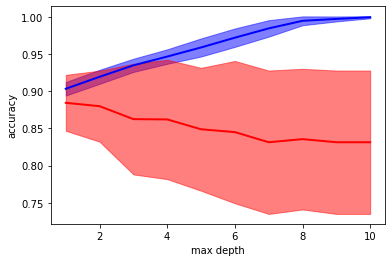

In [146]:
train_score_mean = tree_train_scores.mean(axis=1)
train_score_std = tree_train_scores.std(axis=1)
valid_scores_mean = tree_valid_scores.mean(axis=1)
valid_scores_std = tree_valid_scores.std(axis=1)

plt.fill_between(depths, train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(depths, valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)

plt.plot(depths, train_score_mean, c='b', lw=2)
plt.plot(depths, valid_scores_mean, c='r', lw=2)

plt.xlabel('max depth')
plt.ylabel('accuracy')

In [147]:
model = my_clf = MyDecisionTreeClassifier(data_percentage=1, min_IG=0.0001, \
#                                           max_depth=3, \
                                          criterion='entropy')
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=124)
min_samples_split = range(1, 11)
tree_train_scores, tree_valid_scores = validation_curve(model, X, y, 
                                              'min_samples_split', min_samples_split,
                                              cv=cv, scoring='accuracy')

/Users/alexandernemaltsev/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass param_name=min_samples_split, param_range=range(1, 11) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Text(0, 0.5, 'accuracy')

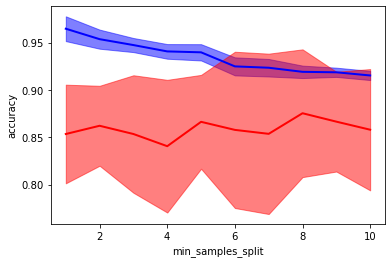

In [148]:
train_score_mean = tree_train_scores.mean(axis=1)
train_score_std = tree_train_scores.std(axis=1)
valid_scores_mean = tree_valid_scores.mean(axis=1)
valid_scores_std = tree_valid_scores.std(axis=1)

plt.fill_between(min_samples_split, train_score_mean-train_score_std, train_score_mean+train_score_std, 
                 color='b', interpolate=True, alpha=0.5,)
plt.fill_between(min_samples_split, valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, \
                 color='r', interpolate=True, alpha=0.5)

plt.plot(min_samples_split, train_score_mean, c='b', lw=2)
plt.plot(min_samples_split, valid_scores_mean, c='r', lw=2)

plt.xlabel('min_samples_split')
plt.ylabel('accuracy')

In [149]:
my_clf = MyDecisionTreeClassifier(data_percentage=0.1, min_IG=0.0001, max_depth=3, \
                                  criterion='entropy', min_samples_split=8)
my_clf.fit(X_train, y_train);

accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test), \
my_clf.predict(X_test), y_test

(0.8936170212765957,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0]))

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [150]:
my_clf = MyDecisionTreeClassifier(data_percentage=1, min_IG=0.0001, criterion='entropy', \
                                  max_depth=5,  min_samples_split=8)
my_clf.fit(X, y);

In [156]:
wt_f = pd.Series(my_clf.get_feature_importance(), name='weight')
nm_f = pd.Series(res_df.columns[1:], name='name')
pd.concat([wt_f,nm_f], axis=1).sort_values(by='weight', ascending=False).head(10)

,weight,name
40,0.220876,sinc2_1_f
0,0.169014,int_corr
4,0.145923,imprelig_m
45,0.136145,attr_o_mean_f
7,0.115891,exphappy_m
37,0.079997,amb1_1_f
30,0.058455,date_f
32,0.047608,exphappy_f
3,0.041323,imprace_m
46,0.031548,shar_o_mean_f


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

